In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [ ]:
from __future__ import division
import argparse
import os
from datetime import datetime
import atari_py
import numpy as np
import torch
import wandb

from agent import Agent
from env import Env
from memory import ReplayMemory
from tqdm import tqdm, trange
import pickle
import bz2

import matplotlib
import matplotlib.pyplot as plt
import cv2

### Repeating arg-parse args just to make my life easier

In [4]:
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)

_StoreAction(option_strings=['--memory-save-folder'], dest='memory_save_folder', nargs=None, const=None, default='/misc/vlgscratch4/LakeGroup/guy/rainbow_memory', type=None, choices=None, help=None, metavar=None)

In [5]:
args = parser.parse_args([])

np.random.seed(args.seed)
# TODO: why not just fix the torch seed to the same one as np?
# torch.manual_seed(np.random.randint(1, 10000))
torch.manual_seed(args.seed)

if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  # torch.cuda.manual_seed(np.random.randint(1, 10000))
  torch.cuda.manual_seed(args.seed)
  torch.backends.cudnn.enabled = args.enable_cudnn
else:
  args.device = torch.device('cpu')

args.evaluation_size = 20
args.game = 'frostbite'

### Create the environment

In [7]:
env = Env(args)
env.train()
action_space = env.action_space()

### Create the naive, doctored background frame

In [8]:
state_0, done = env.reset(), False

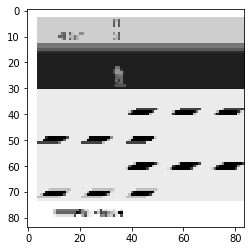

In [9]:
plt.imshow(state_0[3].cpu().numpy(), cmap='Greys')

In [10]:
s_0_np = state_0[3].cpu().numpy()

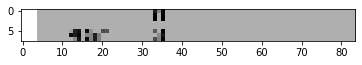

In [11]:
plt.imshow(s_0_np[4:12, :], cmap='Greys')

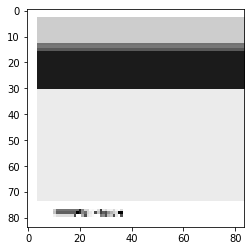

In [12]:
doctored_s_0_np = np.copy(s_0_np)
doctored_s_0_np[4:12,4:] = doctored_s_0_np[6,10]
doctored_s_0_np[16:31,4:] = doctored_s_0_np[20,10]
doctored_s_0_np[31:74,4:] = doctored_s_0_np[33,10]
plt.imshow(doctored_s_0_np, cmap='Greys')

## Starting to play around with color-based classifiers

In [20]:
NROWS = 1
NCOLS = 5
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0


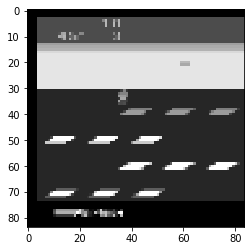

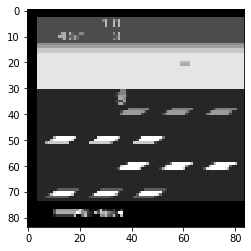

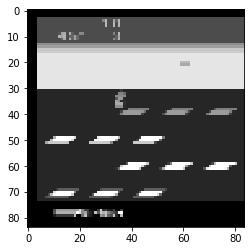

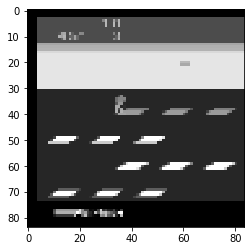

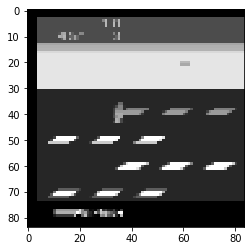

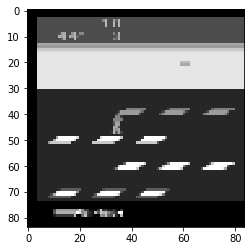

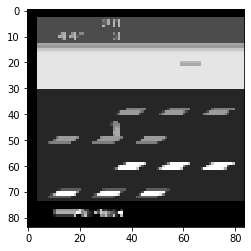

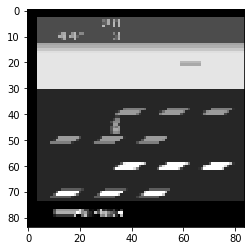

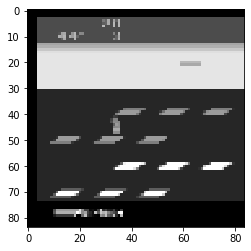

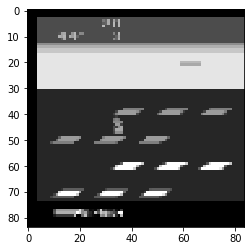

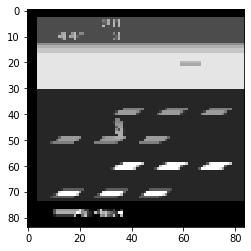

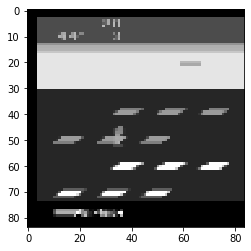

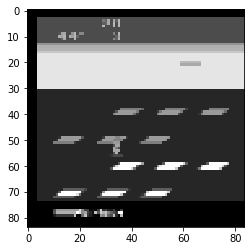

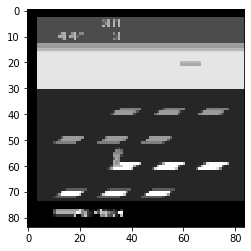

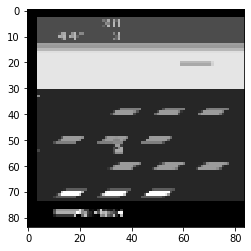

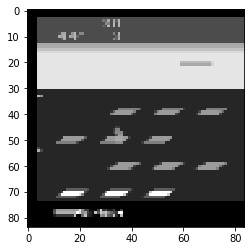

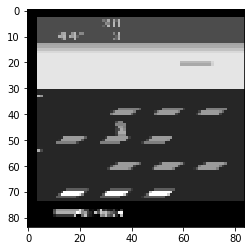

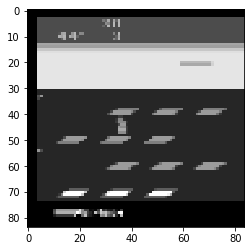

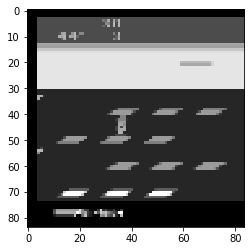

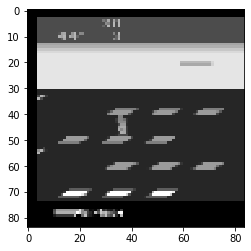

In [14]:
MIN_FRAME_TO_PLOT = 20

torch_states = []
np_states = []


val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for frame in range(40):
    
    if done:
        state, done = env.reset(), False

    torch_states.append(state)
    np_state = state.cpu().numpy()
    np_states.append(np_state)
    
    if frame >= MIN_FRAME_TO_PLOT:
        plt.imshow(np_state[3], cmap='gray'); plt.show()
        
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

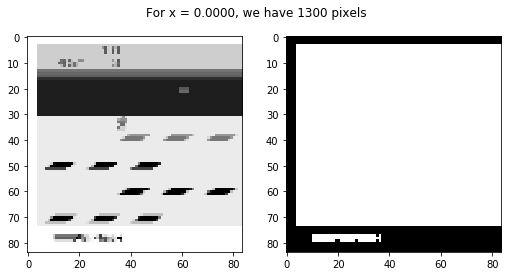

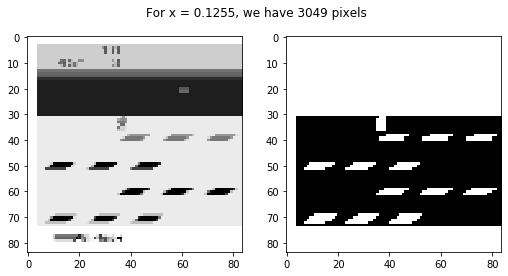

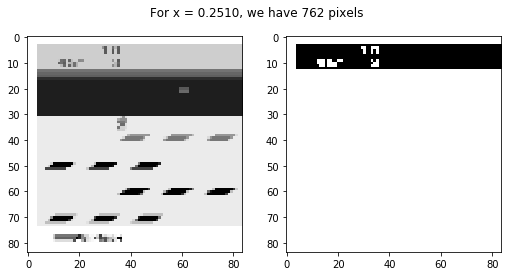

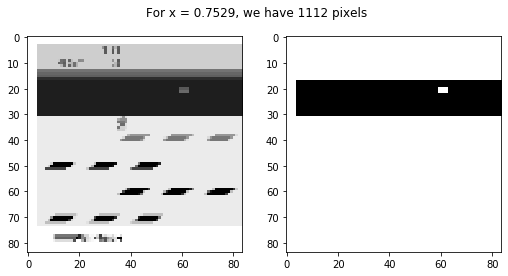

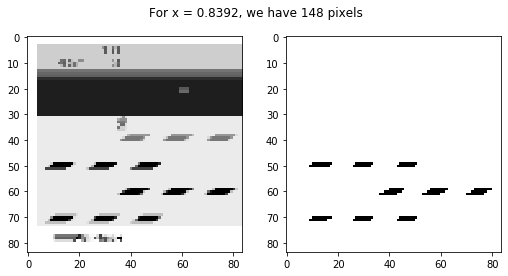

In [26]:
NCOLS = 2
NROWS = 1
INDEX = 20

state = np_states[INDEX][3]

for x in np.unique(state):
    count = np.sum(state == x)
#     print(x, count)
    if count > 100:
        state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)
        
        plt.suptitle(f'For x = {x:.4f}, we have {count} pixels')
        
        state_ax = plt.subplot(NROWS, NCOLS, 1)
        state_ax.imshow(state, cmap='Greys')
        
        mask_ax = plt.subplot(NROWS, NCOLS, 2)
        mask_ax.imshow((state == x).astype(np.uint8), cmap='Greys')
        

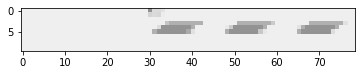

In [29]:
plt.imshow(state[35:45, 5:], cmap='Greys', norm=matplotlib.colors.Normalize(0, 1))

In [31]:
np.unique(state[35:45, 5:])

array([0.1254902 , 0.12941177, 0.13333334, 0.14509805, 0.16470589,
       0.16862746, 0.19607845, 0.20000002, 0.20392159, 0.22352943,
       0.23529413, 0.2392157 , 0.25490198, 0.27058825, 0.30980393,
       0.3254902 , 0.3372549 , 0.4156863 , 0.41960788, 0.43529415,
       0.5019608 , 0.5058824 , 0.50980395, 0.5176471 ], dtype=float32)

In [32]:
for x in np.unique(state[35:45, 5:]):
    count = np.sum(state[35:45, 5:] == x)
    print(x, count)


0.1254902 695
0.12941177 1
0.13333334 1
0.14509805 1
0.16470589 1
0.16862746 1
0.19607845 1
0.20000002 2
0.20392159 1
0.22352943 2
0.23529413 2
0.2392157 1
0.25490198 1
0.27058825 1
0.30980393 2
0.3254902 1
0.3372549 1
0.4156863 30
0.41960788 1
0.43529415 1
0.5019608 1
0.5058824 1
0.50980395 40
0.5176471 1


In [60]:
raw_screen = np.squeeze(env.ale.getScreenGrayscale())

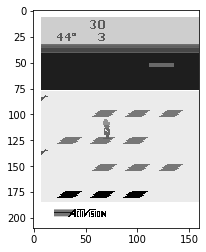

In [61]:
plt.imshow(raw_screen, cmap='Greys')

In [41]:
for x in np.unique(raw_screen):
    count = np.sum(raw_screen == x)
    print(x, count)

0 6463
32 14807
64 3836
90 20
110 33
129 15
130 997
131 37
132 31
136 152
142 127
143 152
146 152
148 17
149 152
150 152
153 158
167 456
192 5224
193 169
214 450


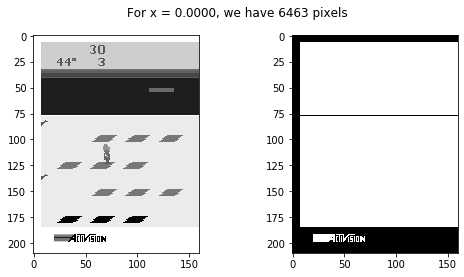

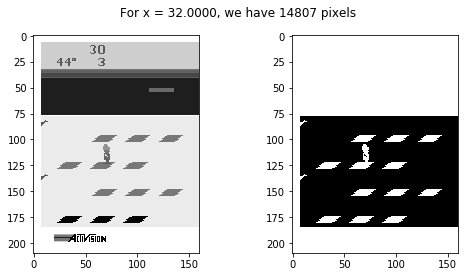

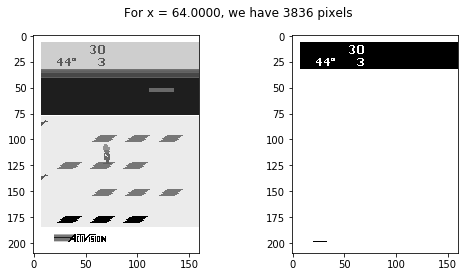

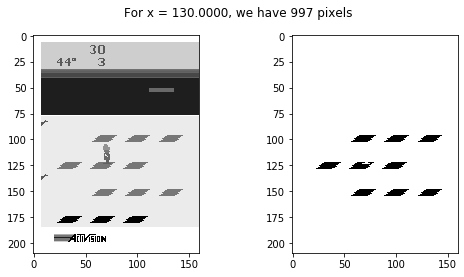

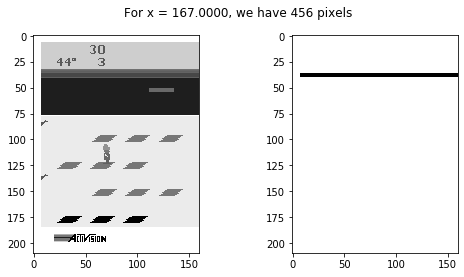

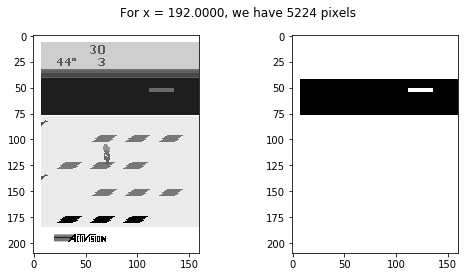

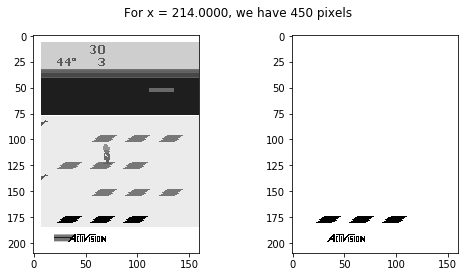

In [43]:
for x in np.unique(raw_screen):
    count = np.sum(raw_screen == x)
#     print(x, count)
    if count > 250:
        state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)
        
        plt.suptitle(f'For x = {x:.4f}, we have {count} pixels')
        
        state_ax = plt.subplot(NROWS, NCOLS, 1)
        state_ax.imshow(raw_screen, cmap='Greys')
        
        mask_ax = plt.subplot(NROWS, NCOLS, 2)
        mask_ax.imshow((raw_screen == x).astype(np.uint8), cmap='Greys')

In [45]:
grayscale_states = []
color_states = []

for _ in range(20):
    grayscale_states.append(env.ale.getScreenGrayscale())
    color_states.append(env.ale.getScreenRGB())

In [46]:
grayscale_states[0].shape

(210, 160, 1)

In [52]:
np.moveaxis(np.concatenate(grayscale_states, axis=2), 2, 0).shape

(20, 210, 160)

In [55]:
np.expand_dims(color_states[0], 0).shape

(1, 210, 160, 3)

In [ ]:
np.concatenate(grayscale_states, axis=2).shape